# Grover's Algorithm: Multiple Marked Elements

This notebook demonstrates Grover's search algorithm to find multiple marked items within an unsorted database using quantum computation.

- We construct a Grover oracle that marks multiple targets.
- We implement the core Grover iteration (oracle + diffusion).
- We test the algorithm on a randomly chosen set of targets and analyze the results.


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import math

from qiskit import transpile
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

## Problem Statement

Given a set of $ N $ elements $ \{x_0, x_1, \ldots, x_{N-1}\} $, the goal is to find a subset of $ m $ marked elements $ \{x_{j_1}, \ldots, x_{j_m}\} $, with $ m \ll N $, using Grover's algorithm.


## Grover Oracle

The oracle flips the phase of each computational basis state corresponding to a marked index. Here, the oracle is constructed to mark multiple target elements in a single circuit.


In [20]:
def grover_oracle(targets: list, n: int):

    qc = QuantumCircuit(n)
    for j in targets:
        j_bin = format(j, f'0{n}b')
        # Step 1: X on qubits where j_bin is '0'
        for i, bit in enumerate(reversed(j_bin)):
            if bit == '0':
                qc.x(i)
        # Step 2: Multi-controlled Z
        if n == 1:
            qc.z(0)
        else:
            qc.h(n-1)
            qc.mcx(list(range(n-1)), n-1)
            qc.h(n-1)
        # Step 3: Undo Xs
        for i, bit in enumerate(reversed(j_bin)):
            if bit == '0':
                qc.x(i)
    qc.name = f"U_f (targets = {targets})"
    return qc


## Grover Iteration

Each Grover iteration applies the oracle for all marked states and then applies the diffusion operator. For multiple marked items, the optimal number of iterations is adjusted.


In [21]:
def grover_operation(qc: QuantumCircuit, targets: list, r: int):

    n = qc.num_qubits
    Uf = grover_oracle(targets, n)
    U0 = grover_oracle([0], n)  # Diffusion operator as phase flip on |0...0>
    for _ in range(r):
        qc.append(Uf, range(n))
        qc.h(range(n))
        qc.append(U0, range(n))
        qc.h(range(n))
        qc.barrier()


## Grover Algorithm (Multiple Targets)

Prepares the quantum register, applies superposition, runs the optimal number of Grover iterations, and measures the results.


In [22]:
def grover_algorithm(qc: QuantumCircuit, targets: list):
    n = qc.num_qubits
    qc.h(range(n))
    r = int(np.trunc(np.pi / 4 * np.sqrt(2**n / len(targets))))
    print(f"Number of Grover iterations: r = {r}")
    grover_operation(qc, targets, r)
    qc.measure_all()


## Result Analysis

Analyze the measurement outcomes, compare the top-m guesses to the actual marked elements, and report if any targets were missed.


In [23]:
def analyze_results(statistics: dict, targets: list, shots: int = 1024) -> None:

    m = len(targets)
    # Get top-m by count
    sorted_items = sorted(statistics.items(), key=lambda kv: kv[1], reverse=True)[:m]
    # Sort those top-m by integer value
    top_sorted = sorted(sorted_items, key=lambda kv: int(kv[0], 2))
    # Extract bitstrings, ints & total correct counts
    top_ints = [int(bs, 2) for bs, _ in top_sorted]
    tot_count = sum(count for _, count in top_sorted)
    wrong_pct = 100 * (1 - tot_count / shots)
    print(f"Wrongly guessed ratio: {wrong_pct:.1f}%")
    print(f"Guessed marked list: {top_ints}")
    print(f"Actual marked list : {sorted(targets)}")
    # Missing
    missing = sorted(set(targets) - set(top_ints))
    if missing:
        print(f"Missing targets: {missing}")
    else:
        print("All targets were found!")


## Run Grover's Algorithm and Visualize Results


Number of Grover iterations: r = 3


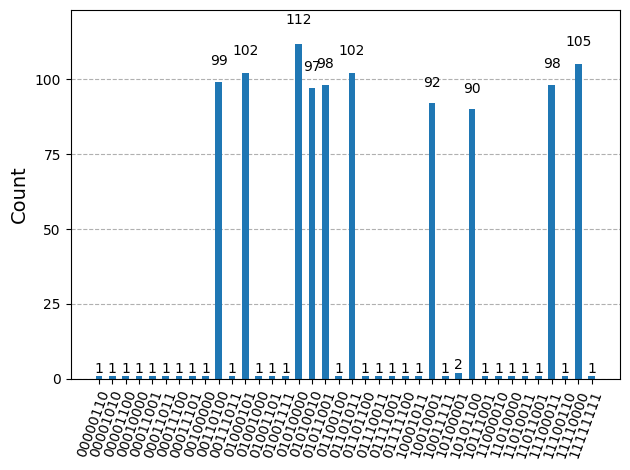

Wrongly guessed ratio: 2.8%
Guessed marked list: [52, 69, 80, 82, 89, 107, 145, 172, 227, 240]
Actual marked list : [52, 69, 80, 82, 89, 107, 145, 172, 227, 240]
All targets were found!


In [24]:
n = 8                   # Number of qubits
m = 10                  # Number of marked items
l = np.random.choice(2**n, size=m, replace=False).tolist()  # Marked elements

qc = QuantumCircuit(n)
grover_algorithm(qc, l) 

# Simulate
qc_transpiled = transpile(qc, backend=AerSimulator())
result = AerSimulator().run(qc_transpiled, shots=1024).result()
statistics = result.get_counts()

display(plot_histogram(statistics))
analyze_results(statistics, l, shots=1024)


## Alternative: Using Qiskit's Built-in GroverOperator

Qiskit provides a built-in `GroverOperator` that automatically combines the oracle and diffusion operator. We use it here for convenience.


In [25]:
from qiskit.circuit.library import GroverOperator

def grover_algorithm2(qc: QuantumCircuit, targets: list):
    n = qc.num_qubits
    Uf = grover_oracle(targets, n)
    grover_op = GroverOperator(oracle=Uf, mcx_mode='noancilla')
    r = int(np.floor(np.pi / 4 * np.sqrt(2**n / len(targets))))
    print(f"Running {r} iterations")
    qc.h(range(n))
    for _ in range(r):
        qc.append(grover_op, range(n))
    qc.measure_all()


Running 3 iterations


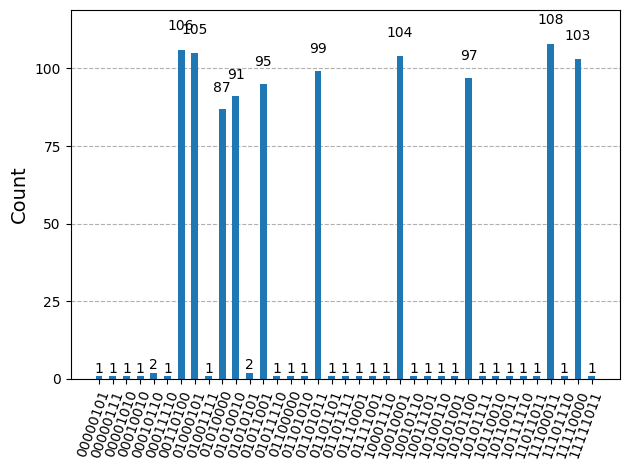

Wrongly guessed ratio: 2.8%
Guessed marked list: [52, 69, 80, 82, 89, 107, 145, 172, 227, 240]
Actual marked list : [52, 69, 80, 82, 89, 107, 145, 172, 227, 240]
All targets were found!


In [26]:
qc = QuantumCircuit(n)
grover_algorithm2(qc, l) 

# Simulate
qc_transpiled = transpile(qc, backend=AerSimulator())
result = AerSimulator().run(qc_transpiled, shots=1024).result()
statistics = result.get_counts()

display(plot_histogram(statistics))
analyze_results(statistics, l, shots=1024)
